In [10]:
import anndata
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

from models import pmVAEModel

In [15]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
from utils import load_annotations
from sklearn.model_selection import train_test_split

# load data

In [3]:
## expression and IHC data

rna_seq = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Datasets_Preprocessed_Expression_Matrix.tsv',sep='\t',index_col=0)
abeta_data = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Datasets_Abeta_IHC_Labels.tsv',index_col=0,sep='\t')

/homes/gws/jjanizek/anaconda3/envs/new_torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# meta data labels 
dataset_labels = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Dataset_Labels.tsv',index_col=0,sep='\t')
region_labels = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Joined_Region_Labels.tsv',index_col=0,sep='\t')

In [6]:
#
# filter microarray data
microarray = dataset_labels['Dataset Label'] == "MSBB_MICROARRAY"
X = rna_seq.loc[~microarray.values,:]

In [8]:
assignment_mat = load_annotations(
    'data/h.all.v7.4.symbols.gmt',
    X.columns,
    min_genes=20
)

In [9]:
membership_mask = assignment_mat.astype(bool).T

In [11]:
## we should probably clean this up and put it in its own importable file

from torch.utils.data import Dataset, DataLoader
class RNASeqData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        if self.y is None and self.c is not None:
            return sample, self.c[index]
        else:
            return sample

# train models with no dataset / region conditioning

In [13]:
ADVAE = pmVAEModel(
        membership_mask.values,
        [12],
        4,
        beta=1e-05,
        terms=membership_mask.index,
        add_auxiliary_module=True)

In [18]:
unconditional_rand_scores = []
unconditional_test_mse = []

for i in range(10):
    
    X_train, X_test = train_test_split(
        X,
        test_size=0.25,
        shuffle=True,
        random_state=i)
    
    
    ADVAE = pmVAEModel(
        membership_mask.values,
        [12],
        4,
        beta=1e-05,
        terms=membership_mask.index,
        add_auxiliary_module=True)
    
    
    train_ds = RNASeqData(X_train.values)
    test_ds = RNASeqData(X_test.values)
    
    ADVAE.train(train_ds, test_ds,batch_size=32,
                max_epochs=50,
                checkpoint_path='pmvae_no_c_4d_repeat_'+ str(i)+ '_030222.pkl')
    
    ADVAE.load_checkpoint('pmvae_no_c_4d_repeat_' + str(i) + '_030222.pkl.best_loss')
    
    outputs = ADVAE.model(torch.tensor(X.values).cuda().float())

    latent_space = pd.DataFrame(
        outputs.z.detach().cpu().numpy(),
        index=X.index,
        columns=ADVAE.latent_space_names())

    

    tsne = TSNE(n_components=2,perplexity=40.0)
    tsne = pd.DataFrame(
        TSNE().fit_transform(latent_space.values),
        index=latent_space.index,
        columns=['tsne 1', 'tsne 2'])
    
    kmeans = KMeans(n_clusters=6, random_state=0).fit(tsne)
    
    unconditional_rand_scores.append(adjusted_rand_score(dataset_labels['Dataset Label'].values[~microarray],kmeans.labels_))
    
    test_outputs = ADVAE.model(torch.tensor(X_test.values).cuda().float())
    
    unconditional_test_mse.append(F.mse_loss(test_outputs.global_recon, torch.tensor(X_test.values).cuda().float()).item())

-------- Epoch 000 --------
Epoch 000: training loss 13044.4909,validation loss 11758.1640
-------- Epoch 001 --------
Epoch 001: training loss 11848.1270,validation loss 11224.8703
-------- Epoch 002 --------
Epoch 002: training loss 11475.5509,validation loss 10974.6418
-------- Epoch 003 --------
Epoch 003: training loss 11279.4770,validation loss 10830.1279
-------- Epoch 004 --------
Epoch 004: training loss 11109.2604,validation loss 10701.8593
-------- Epoch 005 --------
Epoch 005: training loss 10947.4038,validation loss 10499.7571
-------- Epoch 006 --------
Epoch 006: training loss 10724.9951,validation loss 10245.5490
-------- Epoch 007 --------
Epoch 007: training loss 10547.9829,validation loss 10147.5860
-------- Epoch 008 --------
Epoch 008: training loss 10355.2398,validation loss 9974.7240
-------- Epoch 009 --------
Epoch 009: training loss 10175.1927,validation loss 9777.4967
-------- Epoch 010 --------
Epoch 010: training loss 10019.7977,validation loss 9610.5334
--

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13414.3885,validation loss 11458.5587
-------- Epoch 001 --------
Epoch 001: training loss 11987.9965,validation loss 10534.8994
-------- Epoch 002 --------
Epoch 002: training loss 11355.8781,validation loss 10171.3553
-------- Epoch 003 --------
Epoch 003: training loss 11040.5933,validation loss 10025.5901
-------- Epoch 004 --------
Epoch 004: training loss 10792.4484,validation loss 9767.3522
-------- Epoch 005 --------
Epoch 005: training loss 10628.1992,validation loss 9622.9839
-------- Epoch 006 --------
Epoch 006: training loss 10459.1669,validation loss 9516.8341
-------- Epoch 007 --------
Epoch 007: training loss 10324.8885,validation loss 9439.0096
-------- Epoch 008 --------
Epoch 008: training loss 10207.7070,validation loss 9209.6856
-------- Epoch 009 --------
Epoch 009: training loss 10023.6496,validation loss 9045.2037
-------- Epoch 010 --------
Epoch 010: training loss 9829.9412,validation loss 8888.7950
-------- Epoch 011 --------
Epoch 0

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 12754.1414,validation loss 189632.9277
-------- Epoch 001 --------
Epoch 001: training loss 11468.4755,validation loss 12136.2801
-------- Epoch 002 --------
Epoch 002: training loss 11126.8861,validation loss 11779.7686
-------- Epoch 003 --------
Epoch 003: training loss 10910.1636,validation loss 11614.1078
-------- Epoch 004 --------
Epoch 004: training loss 10720.3835,validation loss 11375.3963
-------- Epoch 005 --------
Epoch 005: training loss 10446.5853,validation loss 11125.0442
-------- Epoch 006 --------
Epoch 006: training loss 10147.3515,validation loss 10815.5106
-------- Epoch 007 --------
Epoch 007: training loss 9971.7187,validation loss 10656.7984
-------- Epoch 008 --------
Epoch 008: training loss 9850.2109,validation loss 10535.2853
-------- Epoch 009 --------
Epoch 009: training loss 9718.5004,validation loss 10390.5658
-------- Epoch 010 --------
Epoch 010: training loss 9620.9289,validation loss 10122.1629
-------- Epoch 011 --------
Ep

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13056.9705,validation loss 12003.1018
-------- Epoch 001 --------
Epoch 001: training loss 11823.6567,validation loss 11370.2397
-------- Epoch 002 --------
Epoch 002: training loss 11439.7336,validation loss 11125.6955
-------- Epoch 003 --------
Epoch 003: training loss 11177.4734,validation loss 10920.2947
-------- Epoch 004 --------
Epoch 004: training loss 11025.5453,validation loss 10784.8363
-------- Epoch 005 --------
Epoch 005: training loss 10910.0432,validation loss 10667.9821
-------- Epoch 006 --------
Epoch 006: training loss 10769.2143,validation loss 10500.8307
-------- Epoch 007 --------
Epoch 007: training loss 10647.0084,validation loss 10403.5592
-------- Epoch 008 --------
Epoch 008: training loss 10492.0205,validation loss 10201.3572
-------- Epoch 009 --------
Epoch 009: training loss 10263.1052,validation loss 9974.5325
-------- Epoch 010 --------
Epoch 010: training loss 10043.0760,validation loss 9762.9674
-------- Epoch 011 --------
E

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13229.3849,validation loss 11764.6493
-------- Epoch 001 --------
Epoch 001: training loss 12013.4565,validation loss 11289.1946
-------- Epoch 002 --------
Epoch 002: training loss 11377.4814,validation loss 10767.9861
-------- Epoch 003 --------
Epoch 003: training loss 10969.3736,validation loss 10314.1771
-------- Epoch 004 --------
Epoch 004: training loss 10645.5198,validation loss 10139.3018
-------- Epoch 005 --------
Epoch 005: training loss 10461.0251,validation loss 9973.7915
-------- Epoch 006 --------
Epoch 006: training loss 10308.7270,validation loss 9822.9932
-------- Epoch 007 --------
Epoch 007: training loss 10175.5904,validation loss 9703.8716
-------- Epoch 008 --------
Epoch 008: training loss 10057.6275,validation loss 9598.6659
-------- Epoch 009 --------
Epoch 009: training loss 10014.3080,validation loss 9511.1925
-------- Epoch 010 --------
Epoch 010: training loss 9884.8398,validation loss 9407.4160
-------- Epoch 011 --------
Epoch 

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13221.3451,validation loss 11664.1157
-------- Epoch 001 --------
Epoch 001: training loss 11914.0821,validation loss 11021.9801
-------- Epoch 002 --------
Epoch 002: training loss 11511.4900,validation loss 10820.8769
-------- Epoch 003 --------
Epoch 003: training loss 11253.1946,validation loss 10624.5531
-------- Epoch 004 --------
Epoch 004: training loss 11112.2867,validation loss 10459.7702
-------- Epoch 005 --------
Epoch 005: training loss 10998.5179,validation loss 10383.9512
-------- Epoch 006 --------
Epoch 006: training loss 10804.0388,validation loss 10138.4385
-------- Epoch 007 --------
Epoch 007: training loss 10441.7132,validation loss 9798.1259
-------- Epoch 008 --------
Epoch 008: training loss 10240.6855,validation loss 9618.6136
-------- Epoch 009 --------
Epoch 009: training loss 10103.9475,validation loss 9498.2533
-------- Epoch 010 --------
Epoch 010: training loss 9953.3325,validation loss 9421.3430
-------- Epoch 011 --------
Epoc

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13112.2485,validation loss 11895.7565
-------- Epoch 001 --------
Epoch 001: training loss 12055.9907,validation loss 11277.3984
-------- Epoch 002 --------
Epoch 002: training loss 11499.5557,validation loss 10864.4864
-------- Epoch 003 --------
Epoch 003: training loss 11173.3394,validation loss 10445.4847
-------- Epoch 004 --------
Epoch 004: training loss 10756.7607,validation loss 10194.9567
-------- Epoch 005 --------
Epoch 005: training loss 10570.7301,validation loss 10037.6590
-------- Epoch 006 --------
Epoch 006: training loss 10438.5828,validation loss 9922.8148
-------- Epoch 007 --------
Epoch 007: training loss 10243.7054,validation loss 9838.8121
-------- Epoch 008 --------
Epoch 008: training loss 10153.9776,validation loss 9732.2352
-------- Epoch 009 --------
Epoch 009: training loss 10051.4118,validation loss 9608.9278
-------- Epoch 010 --------
Epoch 010: training loss 9972.6005,validation loss 9624.4859
-------- Epoch 011 --------
Epoch

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 12568.2013,validation loss 443083.9446
-------- Epoch 001 --------
Epoch 001: training loss 11272.6835,validation loss 14816.5917
-------- Epoch 002 --------
Epoch 002: training loss 10776.2210,validation loss 12171.0235
-------- Epoch 003 --------
Epoch 003: training loss 10352.0060,validation loss 11760.4163
-------- Epoch 004 --------
Epoch 004: training loss 10086.1745,validation loss 11502.9264
-------- Epoch 005 --------
Epoch 005: training loss 9882.3737,validation loss 11414.6074
-------- Epoch 006 --------
Epoch 006: training loss 9743.7603,validation loss 11231.4900
-------- Epoch 007 --------
Epoch 007: training loss 9614.7048,validation loss 11112.3480
-------- Epoch 008 --------
Epoch 008: training loss 9507.8499,validation loss 10963.5069
-------- Epoch 009 --------
Epoch 009: training loss 9443.5671,validation loss 10909.3692
-------- Epoch 010 --------
Epoch 010: training loss 9355.7445,validation loss 10836.2224
-------- Epoch 011 --------
Epoc

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 12769.8038,validation loss 13983854.5920
-------- Epoch 001 --------
Epoch 001: training loss 11365.3425,validation loss 12219.0027
-------- Epoch 002 --------
Epoch 002: training loss 10789.8590,validation loss 11631.1970
-------- Epoch 003 --------
Epoch 003: training loss 10449.5867,validation loss 11348.8217
-------- Epoch 004 --------
Epoch 004: training loss 10269.8030,validation loss 11118.1077
-------- Epoch 005 --------
Epoch 005: training loss 10045.1715,validation loss 11059.6459
-------- Epoch 006 --------
Epoch 006: training loss 9947.0214,validation loss 10818.1225
-------- Epoch 007 --------
Epoch 007: training loss 9800.1356,validation loss 10739.8820
-------- Epoch 008 --------
Epoch 008: training loss 9721.7841,validation loss 10680.8905
-------- Epoch 009 --------
Epoch 009: training loss 9611.2945,validation loss 10577.0491
-------- Epoch 010 --------
Epoch 010: training loss 9500.5065,validation loss 10505.1559
-------- Epoch 011 --------
E

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13378.4943,validation loss 11163.6107
-------- Epoch 001 --------
Epoch 001: training loss 11999.5541,validation loss 10647.3230
-------- Epoch 002 --------
Epoch 002: training loss 11506.3317,validation loss 10228.6100
-------- Epoch 003 --------
Epoch 003: training loss 11037.8965,validation loss 9960.7251
-------- Epoch 004 --------
Epoch 004: training loss 10810.9904,validation loss 9833.2192
-------- Epoch 005 --------
Epoch 005: training loss 10580.2277,validation loss 9652.2398
-------- Epoch 006 --------
Epoch 006: training loss 10430.9672,validation loss 9430.9714
-------- Epoch 007 --------
Epoch 007: training loss 10325.7462,validation loss 9382.2181
-------- Epoch 008 --------
Epoch 008: training loss 10223.9445,validation loss 9245.3748
-------- Epoch 009 --------
Epoch 009: training loss 10121.1492,validation loss 9138.2411
-------- Epoch 010 --------
Epoch 010: training loss 10070.5744,validation loss 9098.8618
-------- Epoch 011 --------
Epoch 0

# train models with dataset / region conditioning

In [21]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

c_array = np.concatenate((region_labels.Region.values.reshape(-1,1),
                          dataset_labels['Dataset Label'].values.reshape(-1,1)),axis=1)

enc.fit(c_array)

pre_processed_c_array = enc.transform(c_array).toarray()

microarray = dataset_labels['Dataset Label'] == "MSBB_MICROARRAY"

X = rna_seq.loc[~microarray.values,:]
pre_processed_c_array = pre_processed_c_array[~microarray,:]

assignment_mat = load_annotations(
    'data/h.all.v7.4.symbols.gmt',
    X.columns,
    min_genes=20
)

membership_mask = assignment_mat.astype(bool).T

In [27]:
hsic_conditional_rand_scores = []
hsic_conditional_test_mse = []

for i in range(10):
    
    X_train, X_test, c_train, c_test = train_test_split(
        X, pre_processed_c_array,
        test_size=0.25,
        shuffle=True,
        random_state=i,
    )
    
    
    ADVAE = pmVAEModel(
        membership_mask.values,
        [12],
        4,
        cdim = c_train.shape[1],
        hsic_penalty=1.0e6,#hsic_penalty=1.0e6,
        beta=1e-05,
        terms=membership_mask.index,
        add_auxiliary_module=True
    )
    
    
    train_ds = RNASeqData(X_train.values, c=c_train)
    test_ds = RNASeqData(X_test.values, c=c_test)
    
    ADVAE.train(train_ds, test_ds, batch_size=32,
                max_epochs=50,
                checkpoint_path='pmvae_HSIC_4d_repeat_'+ str(i)+ '_030222.pkl')
    
    ADVAE.load_checkpoint('pmvae_HSIC_4d_repeat_' + str(i) + '_030222.pkl.best_loss')
    
    outputs = ADVAE.model(torch.tensor(X.values).cuda().float(),
                          torch.tensor(pre_processed_c_array).cuda().float())

    latent_space = pd.DataFrame(
        outputs.z.detach().cpu().numpy(),
        index=X.index,
        columns=ADVAE.latent_space_names())

    

    tsne = TSNE(n_components=2,perplexity=40.0)
    tsne = pd.DataFrame(
        TSNE().fit_transform(latent_space.values),
        index=latent_space.index,
        columns=['tsne 1', 'tsne 2'])
    
    kmeans = KMeans(n_clusters=6, random_state=0).fit(tsne)
    
    hsic_conditional_rand_scores.append(adjusted_rand_score(dataset_labels['Dataset Label'].values[~microarray],kmeans.labels_))
    
    test_outputs = ADVAE.model(torch.tensor(X_test.values).cuda().float(),
                               torch.tensor(c_test).cuda().float())
    
    hsic_conditional_test_mse.append(F.mse_loss(test_outputs.global_recon, torch.tensor(X_test.values).cuda().float()).item())

-------- Epoch 000 --------


/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13729.6083,validation loss 11698.0188
-------- Epoch 001 --------
Epoch 001: training loss 12111.5148,validation loss 10631.5992
-------- Epoch 002 --------
Epoch 002: training loss 11443.3245,validation loss 10230.3455
-------- Epoch 003 --------
Epoch 003: training loss 10936.2839,validation loss 9899.6742
-------- Epoch 004 --------
Epoch 004: training loss 10679.2139,validation loss 9613.4061
-------- Epoch 005 --------
Epoch 005: training loss 10436.9265,validation loss 9381.8372
-------- Epoch 006 --------
Epoch 006: training loss 10214.3550,validation loss 9314.8218
-------- Epoch 007 --------
Epoch 007: training loss 10127.0730,validation loss 9178.9609
-------- Epoch 008 --------
Epoch 008: training loss 9986.5681,validation loss 9033.2419
-------- Epoch 009 --------
Epoch 009: training loss 9890.6555,validation loss 9043.1924
-------- Epoch 010 --------
Epoch 010: training loss 9799.7582,validation loss 8970.7740
-------- Epoch 011 --------
Epoch 011:

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13887.1663,validation loss 11379.5307
-------- Epoch 001 --------
Epoch 001: training loss 12388.1065,validation loss 10651.9781
-------- Epoch 002 --------
Epoch 002: training loss 11679.2932,validation loss 9961.4148
-------- Epoch 003 --------
Epoch 003: training loss 11250.1136,validation loss 9730.8758
-------- Epoch 004 --------
Epoch 004: training loss 10922.2161,validation loss 9272.0052
-------- Epoch 005 --------
Epoch 005: training loss 10622.1232,validation loss 9051.4037
-------- Epoch 006 --------
Epoch 006: training loss 10386.9927,validation loss 8840.4319
-------- Epoch 007 --------
Epoch 007: training loss 10252.6353,validation loss 8706.7080
-------- Epoch 008 --------
Epoch 008: training loss 10139.1968,validation loss 8667.0952
-------- Epoch 009 --------
Epoch 009: training loss 10029.2567,validation loss 8527.5633
-------- Epoch 010 --------
Epoch 010: training loss 9956.7029,validation loss 8496.9037
-------- Epoch 011 --------
Epoch 011

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13304.5149,validation loss 152296.7194
-------- Epoch 001 --------
Epoch 001: training loss 11809.5135,validation loss 11591.5486
-------- Epoch 002 --------
Epoch 002: training loss 11090.1691,validation loss 11163.0797
-------- Epoch 003 --------
Epoch 003: training loss 10733.1284,validation loss 10859.9335
-------- Epoch 004 --------
Epoch 004: training loss 10411.3758,validation loss 10529.2384
-------- Epoch 005 --------
Epoch 005: training loss 10180.1519,validation loss 10240.8481
-------- Epoch 006 --------
Epoch 006: training loss 9936.2391,validation loss 9991.2143
-------- Epoch 007 --------
Epoch 007: training loss 9791.3672,validation loss 9802.8167
-------- Epoch 008 --------
Epoch 008: training loss 9710.5130,validation loss 9766.4715
-------- Epoch 009 --------
Epoch 009: training loss 9595.6721,validation loss 9620.4883
-------- Epoch 010 --------
Epoch 010: training loss 9490.2806,validation loss 9593.1382
-------- Epoch 011 --------
Epoch 01

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13660.3584,validation loss 11764.6950
-------- Epoch 001 --------
Epoch 001: training loss 12180.5084,validation loss 11013.6600
-------- Epoch 002 --------
Epoch 002: training loss 11577.2001,validation loss 10502.2842
-------- Epoch 003 --------
Epoch 003: training loss 11094.3614,validation loss 10158.2329
-------- Epoch 004 --------
Epoch 004: training loss 10839.7642,validation loss 10018.2148
-------- Epoch 005 --------
Epoch 005: training loss 10589.5465,validation loss 9692.5179
-------- Epoch 006 --------
Epoch 006: training loss 10356.5200,validation loss 9449.6022
-------- Epoch 007 --------
Epoch 007: training loss 10179.1929,validation loss 9317.4520
-------- Epoch 008 --------
Epoch 008: training loss 10001.8956,validation loss 9177.6734
-------- Epoch 009 --------
Epoch 009: training loss 9895.7147,validation loss 9104.6872
-------- Epoch 010 --------
Epoch 010: training loss 9816.2901,validation loss 8956.9738
-------- Epoch 011 --------
Epoch 0

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13719.5966,validation loss 11529.3384
-------- Epoch 001 --------
Epoch 001: training loss 12168.3152,validation loss 10816.0638
-------- Epoch 002 --------
Epoch 002: training loss 11487.3324,validation loss 10322.6652
-------- Epoch 003 --------
Epoch 003: training loss 11146.9653,validation loss 9968.0691
-------- Epoch 004 --------
Epoch 004: training loss 10857.1577,validation loss 9677.4254
-------- Epoch 005 --------
Epoch 005: training loss 10523.4874,validation loss 9433.0919
-------- Epoch 006 --------
Epoch 006: training loss 10329.3009,validation loss 9335.7077
-------- Epoch 007 --------
Epoch 007: training loss 10227.0229,validation loss 9190.3852
-------- Epoch 008 --------
Epoch 008: training loss 10071.7788,validation loss 8994.4910
-------- Epoch 009 --------
Epoch 009: training loss 9937.8868,validation loss 8974.0317
-------- Epoch 010 --------
Epoch 010: training loss 9784.9334,validation loss 8776.9144
-------- Epoch 011 --------
Epoch 011

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13794.6420,validation loss 11493.3315
-------- Epoch 001 --------
Epoch 001: training loss 12179.9617,validation loss 10673.5880
-------- Epoch 002 --------
Epoch 002: training loss 11517.8275,validation loss 10233.4432
-------- Epoch 003 --------
Epoch 003: training loss 11105.6122,validation loss 9912.7402
-------- Epoch 004 --------
Epoch 004: training loss 10806.7916,validation loss 9663.0077
-------- Epoch 005 --------
Epoch 005: training loss 10538.8050,validation loss 9497.4207
-------- Epoch 006 --------
Epoch 006: training loss 10353.7431,validation loss 9147.2703
-------- Epoch 007 --------
Epoch 007: training loss 10169.5553,validation loss 9002.4949
-------- Epoch 008 --------
Epoch 008: training loss 10014.2360,validation loss 8899.7503
-------- Epoch 009 --------
Epoch 009: training loss 9931.4842,validation loss 8819.0762
-------- Epoch 010 --------
Epoch 010: training loss 9829.0641,validation loss 8747.8140
-------- Epoch 011 --------
Epoch 011

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13681.6174,validation loss 11549.5450
-------- Epoch 001 --------
Epoch 001: training loss 12233.0709,validation loss 10904.2281
-------- Epoch 002 --------
Epoch 002: training loss 11657.7594,validation loss 10388.3466
-------- Epoch 003 --------
Epoch 003: training loss 11103.7952,validation loss 9988.6846
-------- Epoch 004 --------
Epoch 004: training loss 10873.0545,validation loss 9780.5441
-------- Epoch 005 --------
Epoch 005: training loss 10620.3552,validation loss 9524.7647
-------- Epoch 006 --------
Epoch 006: training loss 10353.1565,validation loss 9232.5907
-------- Epoch 007 --------
Epoch 007: training loss 10130.7264,validation loss 9062.8091
-------- Epoch 008 --------
Epoch 008: training loss 10043.7973,validation loss 8982.1924
-------- Epoch 009 --------
Epoch 009: training loss 9917.3843,validation loss 8859.5201
-------- Epoch 010 --------
Epoch 010: training loss 9772.2671,validation loss 8755.0969
-------- Epoch 011 --------
Epoch 011

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13114.1056,validation loss 18004.5528
-------- Epoch 001 --------
Epoch 001: training loss 11625.9447,validation loss 25952.7815
-------- Epoch 002 --------
Epoch 002: training loss 11220.8149,validation loss 23866.4734
-------- Epoch 003 --------
Epoch 003: training loss 11119.9866,validation loss 17915.1567
-------- Epoch 004 --------
Epoch 004: training loss 11131.2564,validation loss 12854.9174
-------- Epoch 005 --------
Epoch 005: training loss 11162.0622,validation loss 74585.6254
-------- Epoch 006 --------
Epoch 006: training loss 11115.2169,validation loss 14331.9388
-------- Epoch 007 --------
Epoch 007: training loss 11168.9693,validation loss 15757.4851
-------- Epoch 008 --------
Epoch 008: training loss 11151.2388,validation loss 13531.2080
-------- Epoch 009 --------
Epoch 009: training loss 11112.3199,validation loss 18878.6085
-------- Epoch 010 --------
Epoch 010: training loss 11132.4653,validation loss 12629.1172
-------- Epoch 011 --------

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13353.2669,validation loss 96521.3169
-------- Epoch 001 --------
Epoch 001: training loss 11956.4259,validation loss 12906.9446
-------- Epoch 002 --------
Epoch 002: training loss 11187.7230,validation loss 11386.8269
-------- Epoch 003 --------
Epoch 003: training loss 10707.1361,validation loss 10968.3889
-------- Epoch 004 --------
Epoch 004: training loss 10330.6390,validation loss 10731.5986
-------- Epoch 005 --------
Epoch 005: training loss 10068.4005,validation loss 10429.6259
-------- Epoch 006 --------
Epoch 006: training loss 9866.7767,validation loss 10198.7887
-------- Epoch 007 --------
Epoch 007: training loss 9741.8925,validation loss 10100.7752
-------- Epoch 008 --------
Epoch 008: training loss 9588.5139,validation loss 9974.9838
-------- Epoch 009 --------
Epoch 009: training loss 9480.9423,validation loss 9830.5150
-------- Epoch 010 --------
Epoch 010: training loss 9396.8357,validation loss 9776.8735
-------- Epoch 011 --------
Epoch 0

/homes/gws/jjanizek/ad_deep_plier/models.py:798: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_weight = torch.tensor(sample_weight, dtype=y_pred.dtype).cuda()


Epoch 000: training loss 13965.4455,validation loss 11208.4593
-------- Epoch 001 --------
Epoch 001: training loss 12458.3583,validation loss 10546.8603
-------- Epoch 002 --------
Epoch 002: training loss 11729.9578,validation loss 9901.6269
-------- Epoch 003 --------
Epoch 003: training loss 11334.0696,validation loss 9571.6916
-------- Epoch 004 --------
Epoch 004: training loss 10932.9029,validation loss 9253.4137
-------- Epoch 005 --------
Epoch 005: training loss 10648.6382,validation loss 9079.6861
-------- Epoch 006 --------
Epoch 006: training loss 10468.9744,validation loss 8957.6875
-------- Epoch 007 --------
Epoch 007: training loss 10361.6254,validation loss 8845.0969
-------- Epoch 008 --------
Epoch 008: training loss 10216.4468,validation loss 8640.7615
-------- Epoch 009 --------
Epoch 009: training loss 10098.2835,validation loss 8527.7630
-------- Epoch 010 --------
Epoch 010: training loss 10005.2997,validation loss 8459.9209
-------- Epoch 011 --------
Epoch 01

In [33]:
all_test_mse = unconditional_test_mse+hsic_conditional_test_mse
all_ari = unconditional_rand_scores+hsic_conditional_rand_scores
all_model_type = ['pmVAE']*10 + ['conditional pmVAE']*10
results_df = pd.DataFrame()
results_df['model'] = all_model_type
results_df['test_mse'] = all_test_mse
results_df['ari'] = all_ari

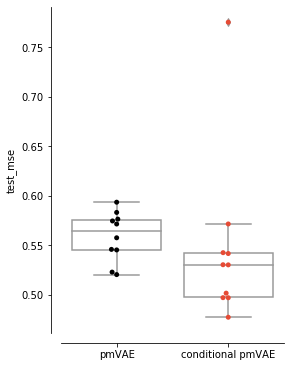

In [37]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(4,6))
ax = sb.swarmplot(data=results_df,x='model',y='test_mse',hue='model',palette=['black','#E64B35FF'])
sb.boxplot(data=results_df,x='model',y='test_mse',palette=['white','white'])
# plt.ylim([500,975])
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for loc, spine in ax.spines.items():
    if loc in ['left','bottom']:
        spine.set_position(('outward', 10))
# plt.savefig('figures/mlp_multiplicative_corr_group_ensemble_panel_Fig3.pdf')
plt.xlabel('')
plt.show()

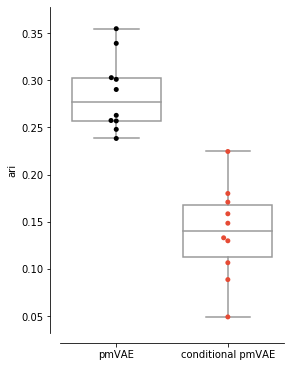

In [38]:
plt.figure(figsize=(4,6))
ax = sb.swarmplot(data=results_df,x='model',y='ari',hue='model',palette=['black','#E64B35FF'])
sb.boxplot(data=results_df,x='model',y='ari',palette=['white','white'])
# plt.ylim([500,975])
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for loc, spine in ax.spines.items():
    if loc in ['left','bottom']:
        spine.set_position(('outward', 10))
# plt.savefig('figures/mlp_multiplicative_corr_group_ensemble_panel_Fig3.pdf')
plt.xlabel('')
plt.show()